<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# Ejercicio de clasificación con redes neuronales (antes Random Forest)

Ejemplo de clasificación utilizando redes neuronales para la clasificación de drogadas que debería tomar un pasiente según su historial clínico<br>

v2.0

### Objetivos:
*   Preprocesar los datos (descarga, lectura, limplieza y filtrado).
*   Conocer la estructura e implementación de las redes neuronales para clasificación binaria en el caso de asignación de drogas para pacientes.



In [91]:
#Librerias a implementar
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import to_categorical

# Recolectar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline1.png" width="1000" align="middle">

### Código de descarga del dataset

In [92]:
if os.access('drug200.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv > drug200.csv
    else:
        !wget drug200.csv https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv

### `drug200.csv`:
El dataset **`drug200.csv`** contiene diferentes tipos de drogas que se le dan a pacientes relativo a su historial clínico. El objetivo es dado un nuevo paciente clasificarlo y determinar que droga es la más apropiada para el.<br> [Dataset source](https://www.kaggle.com/jeevanrh/drug200csv)

- **Age** --> edad, ejemplo 25
- **Sex** --> género, ejemplo F(femenino), M(masculino)
- **BP (Blood Pressure)** --> presión arterial, ejemplo HIGH(alta)
- **Cholesterol** --> colesterol, ejemplo normal (NORMAL)
- **Na / k** --> concentración de sodio/potasio en sangre, ejemplo 7.8
- **Drug** --> droga suministrada, ejemplo drugC

# Procesar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline2.png" width="1000" align="middle">

In [93]:
# Una vez descargado el archivo en Colab.
# Leerlo con Pandas y el método read_csv
# Una vez extraida toda la información se almacena en df
# A partir de df y el método describe(), mostrará la descripción estadistica básica del archivo que se guardará en des
# Crear una fila nueva llamada Nan en el DataFrame  des,
# que indica la cantidad de datos tipo Nan que tiene cada columna.
# Para crear una nueva fila, se utilizará el operador loc, donde se indica el nombre
# de la nueva fila y con que valores se completará.
# La información será de los datos faltantes df.isna().sum()
# Crear una fila nueva llamada %Nan en el DataFrame des,
# Esta fila se completará con los porcentajes de Nan encontrados en cada columna.

df = pd.read_csv("drug200.csv")
des = df.describe()
des.loc['Nan'] = df.isna().sum()
des.loc['%Nan'] = (df.isna().mean())*100
des

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000
Nan,0.000000,0.000000
%Nan,0.000000,0.000000


In [94]:
# Cantidad de filas y columnas con shape
# En la ubicación 0 corresponde a las filas
print('Cantidad de datos en observacion:', df.shape[0])

Cantidad de datos en observacion: 200


# Explorar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline3.png" width="1000" align="middle">

In [95]:
# Exploramos que tan balanceado está el dataset,
# en cuantos casos se suministró cada droga
df['Drug'].value_counts()

drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

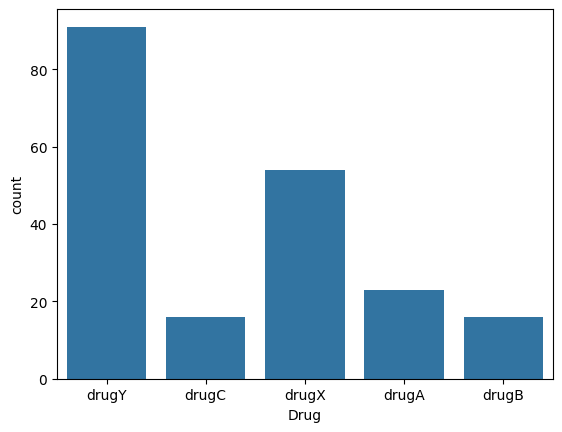

In [96]:
# Graficar la frecuencia de cada droga
# sns, alias de Seaborn
# Método .countplot(), para mostrar un gráfico de barras (de frecuencia)
# Necesita definir la data y el nombre de la columna que se representará en el eje de las 'x' ('Drug')
sns.countplot(data=df, x="Drug")
plt.show()

Se puede observar que en la mayoría de los casos se suministra la drogaY o la drogaX, es muy probable que el modelo siga esta tendencia

#### Transformar variables categóricas texto a clases numeradas

In [97]:
df.head(2)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC


In [98]:
# Se hace una copia de "df" en "df_cod"
df_cod = df.copy()

# Se aplica una función lambda para transformar la categorías de la columna "Drug"
# Crea una columna llamada "DrugY" en el DataFrame df_cod. Para representar la droga más dada (drugY) con el número 1 y las demás con 0
df_cod.loc[:,'DrugY'] = df_cod['Drug'].apply(lambda x: 1 if x == 'drugY' else 0)

# Elimina la columna anterior 'Drug'
# axis=1 para que se elimine por filas
df_cod = df_cod.drop('Drug', axis=1)
df_cod

,Age,Sex,BP,Cholesterol,Na_to_K,DrugY
0,23,F,HIGH,HIGH,25.355,1
1,47,M,LOW,HIGH,13.093,0
2,47,M,LOW,HIGH,10.114,0
3,28,F,NORMAL,HIGH,7.798,0
4,61,F,LOW,HIGH,18.043,1
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,0
196,16,M,LOW,HIGH,12.006,0
197,52,M,NORMAL,HIGH,9.894,0
198,23,M,NORMAL,NORMAL,14.020,0


In [99]:
# Muestra las 5 primeras filas del DataFrame df_cod
df_cod.head()

,Age,Sex,BP,Cholesterol,Na_to_K,DrugY
0,23,F,HIGH,HIGH,25.355,1
1,47,M,LOW,HIGH,13.093,0
2,47,M,LOW,HIGH,10.114,0
3,28,F,NORMAL,HIGH,7.798,0
4,61,F,LOW,HIGH,18.043,1


In [100]:
print(df_cod.columns)

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'DrugY'], dtype='object')


In [101]:
# Se importa la herramienta LabelEncoder de la librería sklearn.preprocessing
# Se importa la herramienta OneHotEncoder de la librería sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoding(df, column):
  ''' Función que recibe un DataFrame y el nombre de una columna
      para asignarle un labelEncoder a los datos de la columna,
      y así transformar a  OneHotEncoder, para luego obtener un nuevo DataFrame
      númerico '''

  # Hace una copia
  df_copy = df.copy()

  # LabelEncoder
  le = LabelEncoder()
  label_encoding = le.fit_transform(df_copy[column])

  # OneHotEncoder
  onehot_encoder = OneHotEncoder(sparse=False)
  one_hot_encoding = onehot_encoder.fit_transform(label_encoding.reshape(-1, 1))

  # Crear las columnas con el resultado del encoder
  one_hot_encoding_df = pd.DataFrame(one_hot_encoding, columns=le.classes_, dtype=int)

  # Agregar sufijo
  one_hot_encoding_df = one_hot_encoding_df.add_prefix(column+'_')

  # Unir nuevas columnas al dataset
  df_copy = df_copy.join(one_hot_encoding_df)

  # Eleminar vieja columna del dataset
  df_copy = df_copy.drop([column], axis=1)
  return df_copy, le, onehot_encoder


In [102]:
# Se invoca a la función en tres oportunidades para transformar
# a las columnas: 'Sex','BP' y 'Cholesterol'
df_cod, le_sex, ohe_sex = one_hot_encoding(df_cod, 'Sex')
df_cod, le_bp, ohe_bp = one_hot_encoding(df_cod, 'BP')
df_cod, le_colest, ohe_colest = one_hot_encoding(df_cod, 'Cholesterol')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [103]:
# Muestra las 5 primeras filas del DataFrame df_cod
df_cod.head()

,Age,Na_to_K,DrugY,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,1,1,0,1,0,0,1,0
1,47,13.093,0,0,1,0,1,0,1,0
2,47,10.114,0,0,1,0,1,0,1,0
3,28,7.798,0,1,0,0,0,1,1,0
4,61,18.043,1,1,0,0,1,0,1,0


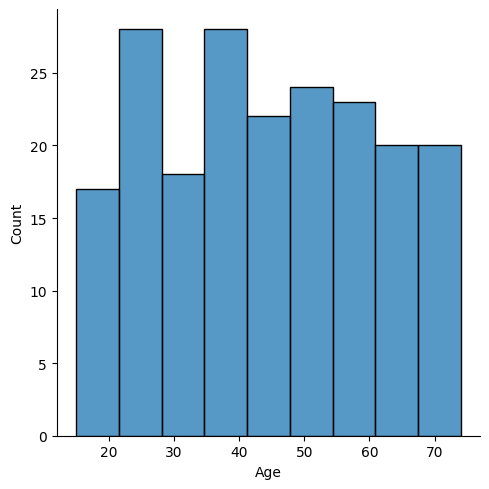

In [104]:
# displot(), esta función brinda acceso a varios enfoques para visualizar la distribución de datos.
# Fuente: https://seaborn.pydata.org/generated/seaborn.displot.html
# sns, alias de Seaborn
# Necesita la data y el nombre de la columna a representar
sns.displot(data=df_cod, x='Age')

# Muestra la figura
plt.show()

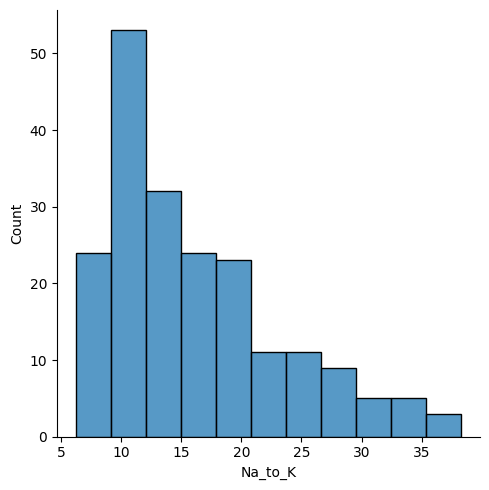

In [105]:
# displot(), esta función brinda acceso a varios enfoques para visualizar la distribución de datos.
# Fuente: https://seaborn.pydata.org/generated/seaborn.displot.html
# sns, alias de Seaborn
# Necesita la data y el nombre de la columna a representar
sns.displot(data=df_cod, x='Na_to_K')

# Muestra la figura
plt.show()

In [106]:
# Se hace una copia (df_norm)  del DataFrame df_cod
df_norm = df_cod.copy()

In [107]:
# Es importante normalizar los datos, ya que las redes funcionan con el proceso
# del gradiente descendente.
# Como "Age" no sigue una distribucion normal y "Na_to_K" no parece tener outliers
# utilizaremos el MinMaxScaler

# Se importa MinMaxScaler de la librería sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Se crea el objeto scaler a partir de la clase MinMaxScaler()
scaler = MinMaxScaler()

# Del DataFrama df_norm se implementa el operador .loc para editar las columnas 'Age', 'Na_to_K'
# Para acceder a las columnas se utiliza los corchetes
# Los dos puntos (:) indican que se editarán todas las filas de la columna indicada
# Para normalizar se utilizá el objeto creado scaler
# y el método .fit_transform, que se encargará de normalizar
# Entre paréntesis se indica el nombre de la columna del DataFrame. Ej:df_norm[['Age']]
df_norm.loc[:, 'Age'] = scaler.fit_transform(df_norm[['Age']])
df_norm.loc[:, 'Na_to_K'] = scaler.fit_transform(df_norm[['Na_to_K']])

# Observar las  5 primeras filas
df_norm.head()

,Age,Na_to_K,DrugY,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,0.135593,0.596848,1,1,0,1,0,0,1,0
1,0.542373,0.213397,0,0,1,0,1,0,1,0
2,0.542373,0.120239,0,0,1,0,1,0,1,0
3,0.220339,0.047814,0,1,0,0,0,1,1,0
4,0.779661,0.368191,1,1,0,0,1,0,1,0


# Entrenar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline4.png" width="1000" align="middle">

El primer paso es obtener los datos que serán la entrada del sistema (X) y los datos que serán la salida del modelo estimador (y)

In [108]:
# Se separan los valores para X e y con el método .values
# Para los valores de X se mantienen la mayoria de las columnas a excepción de la columna 'drug'
# axis=1, parámetro para indicar que se elimine fila a fila
# y representará la columna objetivo, que es la columna que contiene las categorías conocidas para cada fila, que el la columna 'drug'
X = df_norm.drop('DrugY', axis=1).values
y = df_norm['DrugY'].values


In [109]:
# Entrada a la red neuronal
# El [1] indica que solo toma en cuenta el número de columnas --> 9
# shape = (filas, columnas)
in_shape = X.shape[1]

# Salida a la red neuronal
# Es 1, ya que obtendremos un resultado; será uno (DrugY) ó cero (otra droga)
out_shape = 1

Siguiente paso es dividir el dataset en entrenamiento (train) y evaluación (test). Utilizaremos el criterio 80%20%

In [110]:
# Se importa la herramienta de sklearn.model_selectionl como train_test_split
from sklearn.model_selection import train_test_split

# Fijamos un "random_state" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
# Ojo! Los dataset de train y test son array numpy
# Se importa la herramienta de la libreria  train_test_split()
# Necesita los valores de X e y
# test_size=0.2, permite indicar el porcentaje de valores para validar, equivalente a un 20%
# random_state=42,  es un número fijo que utilizan comunmente en documentación, significa que para cada ejecución del algoritmo
#se genere nuevos valores aleatorios
# y los conjuntos de datos de entrenamiento y pruebas serán diferentes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [111]:
# Se importa Dense de la librería tensorflow.keras.layers
from keras.layers import Dense

def create_model(input_size, hidden_neurons, output_size):
  '''Función que recibe en input_size las entradas a la red (cantidad de columnas),
  hidden_neurons (cantidad de neuronas) y output_size (salida de la red). Esta
  función tiene el objetivo crea un model con redes neuronales para clasificación'''
  # Se crea el objeto model2 a partir de la clase Sequential()
  model = Sequential()

  # Crear la capa de entrada y la capa oculta (hidden) de la red, que tendrá:
  # --> tantas entradas (input_shape) como columnas (input_size)
  # --> tantas neuronas como deseemos
  # --> utilizamos "sigmoid" como capa de activación
  model.add(Dense(units=hidden_neurons, activation='sigmoid', input_shape=(input_size,)))

  # Crear la capa de salida, que tendrá tantas neuronas como salidas posibles (2 opciones sigmoid)
  model.add(Dense(units=output_size, activation='sigmoid'))

  return model

In [112]:
in_shape

9

In [113]:
# Se invoca a la función que se encarga de crear el modelos con los valores pasados.
model = create_model(in_shape, 64, out_shape)

# Configuración del modelo para el entrenamiento, implementando el método compile a partir del modelo creado.
# Se necesita indicar los parámetros:
# optimizer, nombre del optimizador (es el algoritmo que se encarga del descenso de gradiente estocástico)
# Fuente: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# loss, se llama función de pérdida, representa las categorías conocidas de las predicción. Al ser 'binary_crossentropy' la predicción tiene
# una salida con dos opciones.
# metrics, se define la métrica que evaluará el modelo durante el entrenamiento y las pruebas.
# learning_rate, tasa de aprendizaje. El valor predeterminado es 0,001.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Se entrena el modelo con el método fit
# Necesita definir los valores para X_train, y_train sumado a la cantidad de épocas que seria la iteraciones de entrenamiento y el porcentaje
# dirigido a validación (validation_split=0.2)
# batch_size, tamaño del lote a entrenar.
history = model.fit(X_train, y_train, validation_split=0.2 , epochs=50, batch_size=32)


Epoch 1/50
4/4 [==============================] - 2s 69ms/step - loss: 0.6987 - accuracy: 0.5391 - val_loss: 0.7057 - val_accuracy: 0.4688
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6879 - accuracy: 0.5078 - val_loss: 0.6972 - val_accuracy: 0.4062
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6801 - accuracy: 0.5703 - val_loss: 0.6949 - val_accuracy: 0.4375
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6700 - accuracy: 0.6328 - val_loss: 0.7024 - val_accuracy: 0.4375
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6646 - accuracy: 0.5859 - val_loss: 0.7049 - val_accuracy: 0.4375
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6612 - accuracy: 0.6016 - val_loss: 0.6949 - val_accuracy: 0.4688
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.6512 - accuracy: 0.6172 - val_loss: 0.6862 - val_accuracy: 0.4688
Epoch 8/50
4/4 [==============

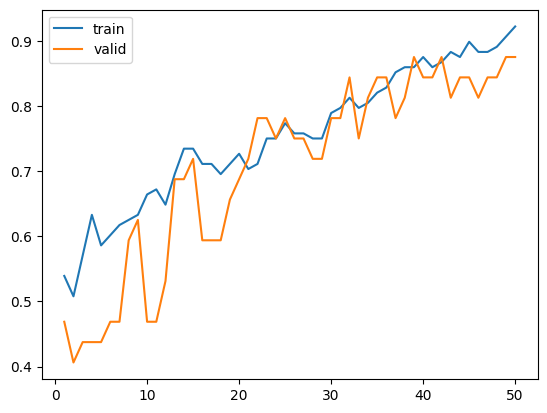

In [114]:
# Variable epocas_conteo, que almacena en una lista la cantidad de épocas de train
# history, es la variable que almacena las predicciones del modelo
# y de ella se puede acceder a información como su historial (history) del accuracy
epocas_conteo= range(1, len(history.history['accuracy']) + 1)
# 1,50

# De Seaborn (sns) se accede al gráfico de línea para representar;
# Por un lado, el 'accuracy',
# Por el otro, la validación (val_accuracy)
sns.lineplot(x=epocas_conteo,  y=history.history['accuracy'], label='train')
sns.lineplot(x=epocas_conteo,  y=history.history['val_accuracy'], label='valid')
plt.show()

In [115]:
# Variable que almacena las probabilidades de las predicciones
# con los datos de evaluación
y_hat_prob = model.predict(X_test)
#y_hat_prob

2/2 [==============================] - 0s 38ms/step


In [116]:
# Para los resultados de las predicciones del modelo,
# Se aplica una nueva  asignación de valores
# Para aquellas probabilidades mayores a 0.5 se cambia a 1
# y las demás a 0
y_hat = [1 if x >= 0.5 else 0 for x in y_hat_prob]
#y_hat

In [117]:
# De model creado se puede acceder al sumario que muestra la estructura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 705 (2.75 KB)
Trainable params: 705 (2.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Validar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline5.png" width="1000" align="middle">

In [118]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)

# Se toma el valor de la ubicación número 1, ya que corresponde al valor de la métrica
# Para la ubicación cero, corresponde al error, valor de pérdida.
# Fuente: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
scores[1]

2/2 [==============================] - 0s 8ms/step - loss: 0.3962 - accuracy: 0.9500


0.949999988079071

In [119]:
# Calcular la exactitud (accuracy)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat, normalize=True)

0.95

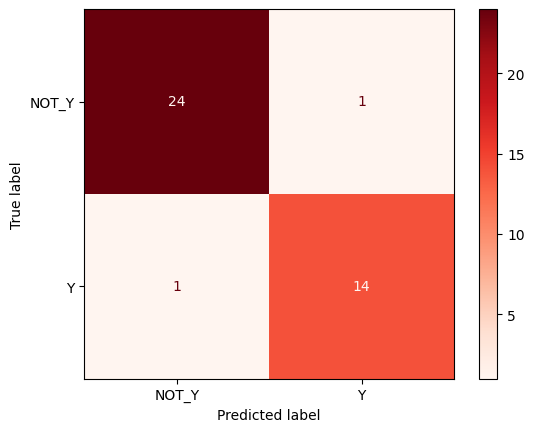

In [120]:
# Se utiliza la matriz de confusión para evaluar la precisión de una clasificación.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Necesita dos variables que contengan los valores a comparar
cm = confusion_matrix(y_test, y_hat)

# Código para realizar la representación gráfica con los resultados
# Se crea la varible cmd, que almacena visualization de la Confusion Matrix
# Necesita la variable cm que contiene los resultados de la comparación entre los valores reales y predicción
# display_labels, se especifica las etiquetas de las categorias que se evalúan.
cmd = ConfusionMatrixDisplay(cm, display_labels=['NOT_Y', 'Y'])

# Con cmd.plot se especifica el mapa de colores reconocido por matplotlib.
cmd.plot(cmap=plt.cm.Reds)

# Mostrar la figura
plt.show()

# Utilizar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline6.png" width="1000" align="middle">

In [130]:
df_norm.head()
# ¿Cuáles serían los datos de entrada?
# Age,	Na_to_K,	Sex,	BP,	Cholesterol

,Age,Na_to_K,DrugY,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,0.135593,0.596848,1,1,0,1,0,0,1,0
1,0.542373,0.213397,0,0,1,0,1,0,1,0
2,0.542373,0.120239,0,0,1,0,1,0,1,0
3,0.220339,0.047814,0,1,0,0,0,1,1,0
4,0.779661,0.368191,1,1,0,0,1,0,1,0


In [122]:
# Datos de prueba
# Se construye el DataFrame
prueba = pd.DataFrame({'Age':[39],'Na_to_K':[28.452],'Sex':['F'], 'BP':['HIGH'], 'Cholesterol':['HIGH']})
prueba


,Age,Na_to_K,Sex,BP,Cholesterol
0,39,28.452,F,HIGH,HIGH


### Los datos tienen que someterse al mismo tratamiento que tuvieron los datos antes del entrenamiento:
* Label Encoder
* OneHotEnder
* Construir un dataframe para los valores transformados
* Agregar sufijo
* Unir el nuevo dataframe con el anterior
* Eliminar la anterior columna de tipo "strings"

In [123]:
# Aplica el label encoder
le_sex_prueba = le_sex.transform(prueba['Sex'])

# Aplica el one hot encoder
sex_ohe_prueba = ohe_sex.transform(le_sex_prueba.reshape(-1, 1))

# Se construye el dataframe con los valores del onehotencoder
df_sex_prueba = pd.DataFrame(sex_ohe_prueba, columns=le_sex.classes_, dtype=int)

# Agregar sufijo
df_sex_prueba = df_sex_prueba.add_prefix('Sex'+'_')

# Unir nuevas columnas al dataset
df_unificado1 = prueba.join(df_sex_prueba)

# Eliminar la columna con los datos strings del dataframe
df_unificado1 = df_unificado1.drop('Sex', axis=1)
df_unificado1

,Age,Na_to_K,BP,Cholesterol,Sex_F,Sex_M
0,39,28.452,HIGH,HIGH,1,0


In [124]:
le_bp_prueba = le_bp.transform(prueba['BP'])
ohe_bp_prueba = ohe_bp.transform(le_bp_prueba.reshape(-1, 1))
df_bp_prueba = pd.DataFrame(ohe_bp_prueba, columns=le_bp.classes_, dtype=int)
# Agregar sufijo
df_bp_prueba = df_bp_prueba.add_prefix('BP'+'_')
# Unir nuevas columnas al dataset
df_unificado2 = df_unificado1.join(df_bp_prueba)
df_unificado2 = df_unificado2.drop('BP', axis=1)
df_unificado2

,Age,Na_to_K,Cholesterol,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL
0,39,28.452,HIGH,1,0,1,0,0


In [125]:
colesterol_le_prueba = le_colest.transform(prueba['Cholesterol'])
colesterol_ohe_prueba = ohe_colest.transform(colesterol_le_prueba.reshape(-1, 1))
df_colesterol_prueba = pd.DataFrame(colesterol_ohe_prueba, columns=le_colest.classes_, dtype=int)
# Agregar sufijo
df_colest_prueba = df_colesterol_prueba.add_prefix('Cholesterol'+'_')
# Unir nuevas columnas al dataset
df_unificado3 = df_unificado2.join(df_colest_prueba)
df_unificado3 = df_unificado3.drop('Cholesterol', axis=1)
df_unificado3

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,39,28.452,1,0,1,0,0,1,0


In [126]:
# Definir los datos para X_prueba con el .values
X_prueba = df_unificado3.values
X_prueba

array([[39.   , 28.452,  1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.   ,
         0.   ]])

In [127]:
# Utilizar el modelo con .predict() y los datos de prueba
prediccion = model.predict(X_prueba)

prediccion1 = np.argmax(prediccion,axis=1)
prediccion1

1/1 [==============================] - 0s 44ms/step


array([0])

In [128]:
resultado = [1 if x >= 0.5 else 0 for x in prediccion]
resultado
# Si el resultado es 1 = DrugY y si es 0= otra droga

[1]